In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scsavailability as scs

from scsavailability import features as feat, model as md, plotting as pt

In [2]:
path = 'C:/Users/Jamie.williams/OneDrive - Newton Europe Ltd/Castle Donnington/Data/'

In [3]:
at = pd.read_csv(path+'active_totes_20201123.csv')
av = pd.read_csv(path+'Availability_with_Grey&Blue_1811-2511.csv')
fa = pd.read_csv(path + 'scs_tote_matched.csv')

In [4]:
at = feat.pre_process_AT(at)

Active Totes Preprocessed


In [5]:
av = feat.pre_process_av(av)

Quadrants Assigned
Modules Assigned
Availability data pre-processed


In [6]:
fa = feat.preprocess_faults(fa,remove_same_location_faults = True)

duplicated location faults removed - max duration kept
Faults Preprocessed


C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:241: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = pd.to_timedelta(fa['Duration'].str.slice(start=2))
C:\Users\Jamie.williams\Anaconda3\lib\site-packages\scsavailability\features.py:242: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fa['Duration'] = fa['Duration'].dt.total_seconds()


In [7]:
fa_floor = feat.floor_shift_time_fa(fa)

Time shifted by 0m


In [42]:
fa_sel = feat.fault_select(fa_floor, select_level = 'Tote Colour', selection = ['Blue','Both'])

fa_agg = feat.faults_aggregate(fa_sel,fault_agg_level='Tote Colour', agg_type = 'count')

Faults aggregated


In [43]:
av_agg = feat.aggregate_availability(av, agg_level = 'Module')
at_agg = feat.aggregate_totes(at, agg_level = 'Module')

Availability data aggregated


In [44]:
df = feat.merge_av_fa_at(av_agg ,at_df=at_agg, fa_df = fa_agg, target = 'Blue Tote Loss',faults=True, totes = True, agg_level = 'Module')

Datasets merged


In [45]:
df.head(5)

,timestamp,Blue Tote Loss,Blue,Both,TOTES
0,2020-11-18 11:00:00,0.506000,67,65,28.833333
1,2020-11-18 11:00:00,0.151333,67,65,47.133333
2,2020-11-18 11:00:00,0.002000,67,65,71.300000
3,2020-11-18 11:00:00,0.016000,67,65,61.366667
4,2020-11-18 11:00:00,0.348000,67,65,31.800000


In [21]:
#df = df[df['Blue Tote Loss']>0.1].reset_index(drop=True)
#df = df[df['TOTES']<60].reset_index(drop=True)

In [22]:
X,y = md.gen_feat_var(df)

Feature Importance Ranking: 
 
    Importance       Feature
0    0.835844         TOTES
1    0.164156  Total Faults

Regression Metrics: 
 
           RF Metrics
MAE         0.091920
MSE         0.015575
RMSE        0.124798
MAPE%            inf
ACC%            -inf
OOB         0.551308
R2_Train    0.936348
R2_Pred     0.547647 

Feature Coefficient Ranking: 
 
    Coefficients       Feature
0     -0.002238         TOTES
1      0.000100  Total Faults

Regression Metrics: 
 
           LM Metrics
MAE         0.126865
MSE         0.025098
RMSE        0.158424
MAPE%            inf
ACC%            -inf
R2_Train    0.261599
R2_Pred     0.271041

Cross Validation Scores LinearRegression(): 
 
        R2 Scores
1       0.312390
2       0.165977
3       0.357489
4       0.317741
5       0.310359
6       0.324914
7       0.207047
8       0.019562
9       0.352519
10      0.142018
Mean    0.251002
STD     0.106516

Cross Validation Scores RandomForestRegressor(oob_score=True): 
 
        R2 Scor

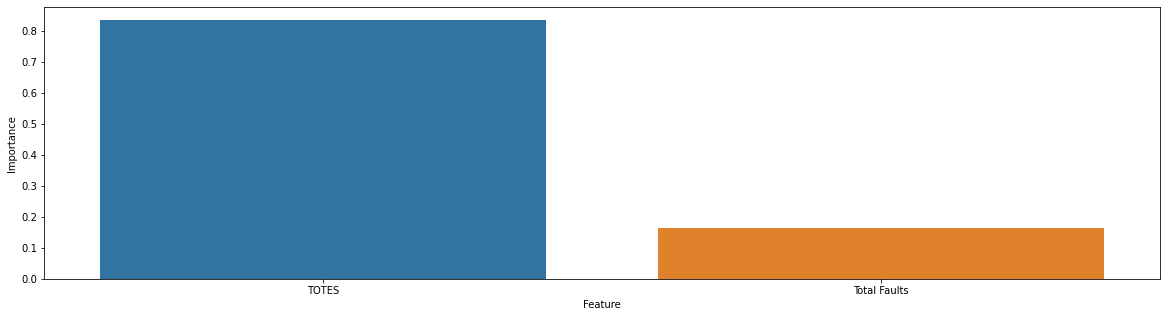

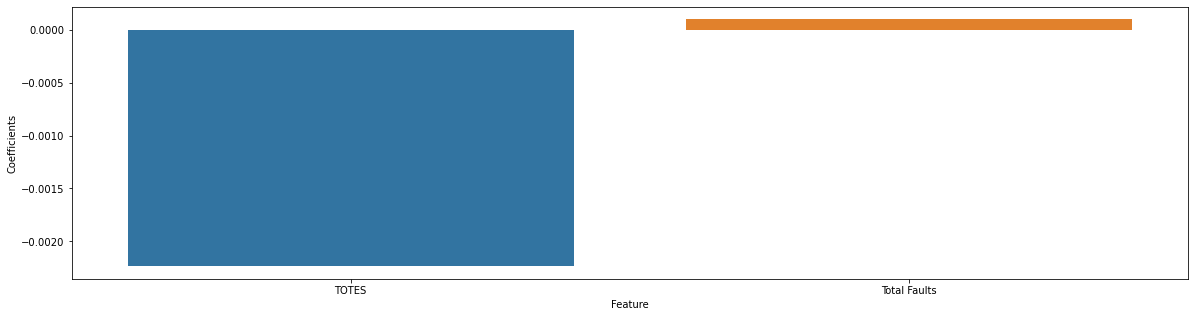

In [23]:
X_train, X_test, y_train, y_test = md.split(X,y,test_size=0.3,random_state=101)

RF_mdl,predictions_RF=md.run_RF_model(X_train, X_test, y_train, y_test,num_trees=100, criterion = 'mse', max_depth=None, dtree=False)

Linear_mdl,predictions_LM=md.run_LR_model(X_train, X_test, y_train, y_test)

cv_R2 = md.cross_validate_r2(Linear_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)

cv_R2 = md.cross_validate_r2(RF_mdl, X, y, n_folds = 10, shuffle = True, random_state = 101)